## Phase contrast imaging using mixed-state ptychography

In this tutorial notebook, we will reconstruct the electrostatic potential of a simulated STO sample using mixed-state ptychography.

### Downloads
* [Incoherently summed STO 4D-STEM dataset](https://drive.google.com/file/d/1q-bDqxiHCXsITxMxS7X63B1sQtbgMyL2/view?usp=share_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

The 4D-STEM dataset used here was simulated in abTEM using the following parameters:
- Convergence angle: 20 mrad
  - Using two orthogonal apertures (see below)
- Accelerating voltage: 300 kV
- Probe aberrations: 100 A defocus
- Poisson noise: 10,000 e/A$^2$

Updated 2023 June 17

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.1


# Load data, basic visualization

First, we load the dataset and plot the mean diffraction pattern:

In [2]:
file_path = 'data/'

In [3]:
dataset=py4DSTEM.read(file_path+"ptycho_STO-110_mixed-state.h5")
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1.1237760874546576
             R_pixel_size:    0.5072051228477243
             Q_pixel_units:   mrad
             R_pixel_units:   A
)

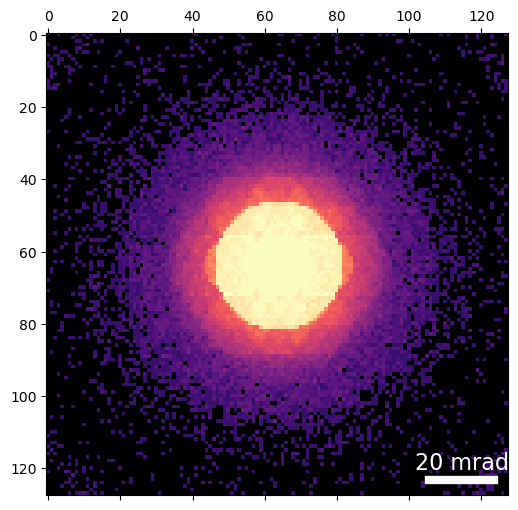

In [4]:
dataset.get_dp_mean()
py4DSTEM.show(
    dataset.tree("dp_mean"),
    cmap='magma',
    power=0.25,
    figsize=(6,6),
)

This is perhaps hard to see due to the noise, but this dataset was simulated by incoherently adding two simulations:
- 75% using a circular aperture between 0-10 mrad
- 25% using an annular aperture between 10-20 mrad

Our aim is to reconstruct the complex object and _both_ the complex probes using the incoherently-summed dataset.

## Single-probe ptychography

First, let's see how well single-probe ptychography fares:

Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.


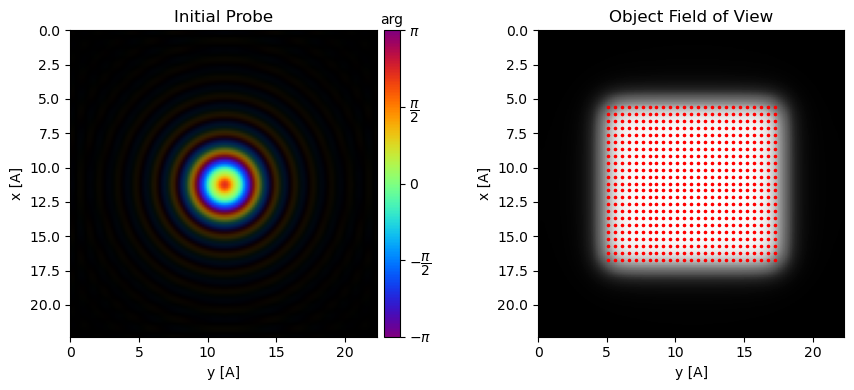

In [5]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset,
    verbose=True,
    energy=200e3,
    semiangle_cutoff=20,
    defocus=100,
    #device='gpu',
    object_padding_px=(0,0),
).preprocess(
    plot_rotation=False,
    plot_center_of_mass = False,
)

Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████| 16/16 [00:32<00:00,  2.00s/ iter]


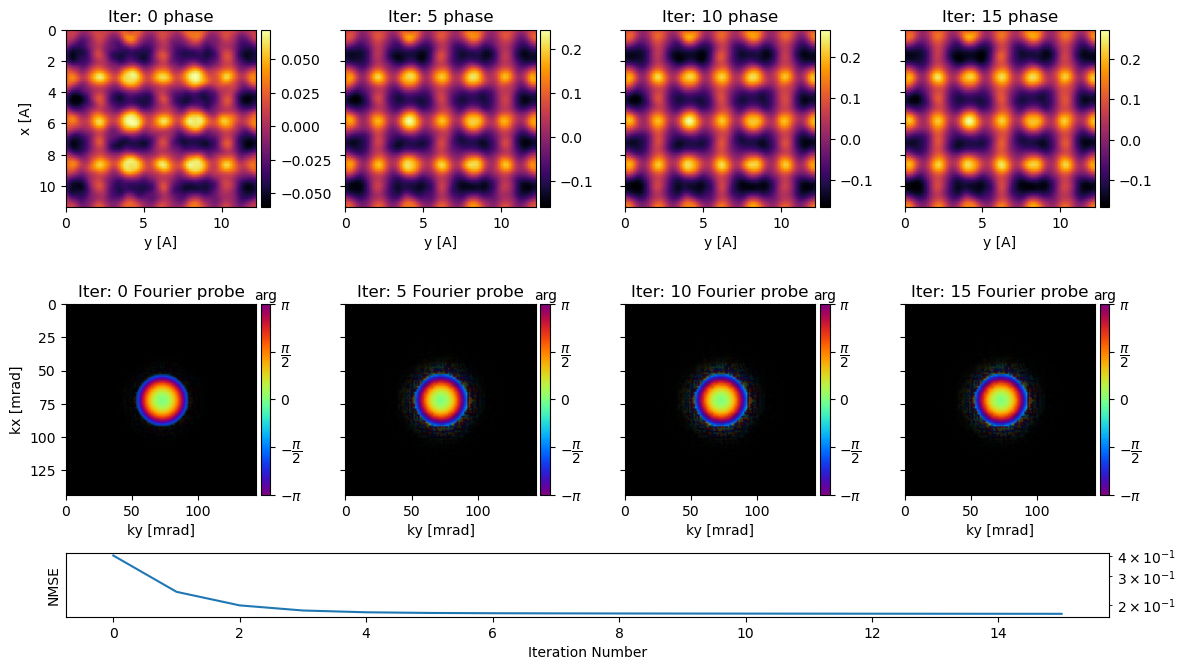

In [6]:
ptycho = ptycho.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    gaussian_filter_sigma=0.125,
    step_size=0.5,
).visualize(
    iterations_grid = 'auto',
    plot_fourier_probe=True,
)

The object does not look great, and notice the large changes in our probe. This is because we started with a guess of a circular aperture of 20mrad, but 75% of the dataset comes from a 10mrad circular aperture. 

We can see this in the complex plot of the probe in Fourier space, which has a substantial "halo" between 10-20 mrad.

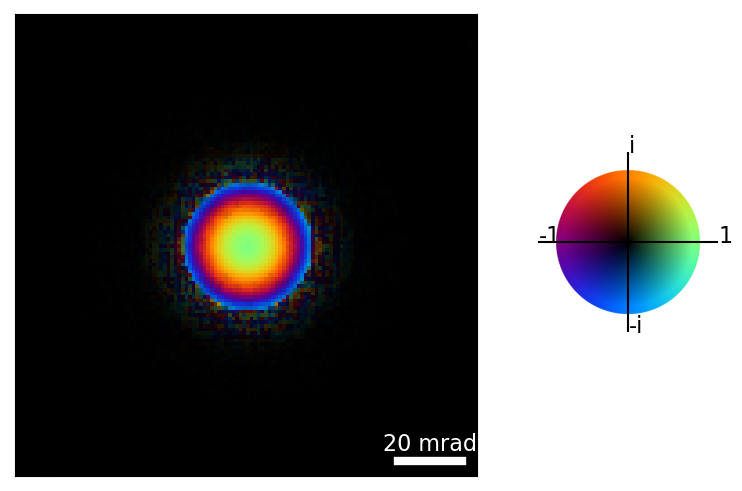

In [7]:
ptycho.show_fourier_probe(
    pixelunits="mrad",
    pixelsize=ptycho.angular_sampling[0],
)

## Mixed-probe ptychography

Let's try this again using our mixed-state algorithm for 2 probe modes:

Best fit rotation = 0 degrees.
No need to transpose diffraction intensities.


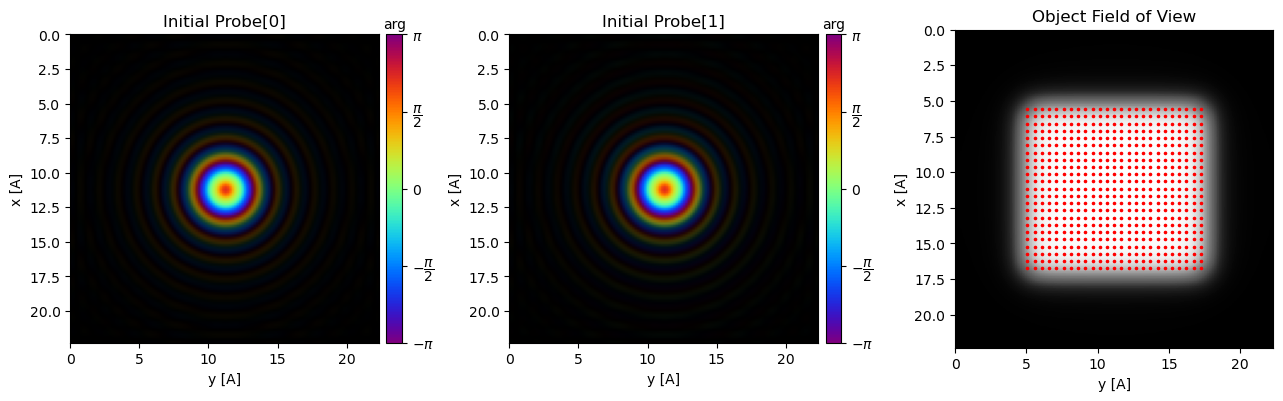

In [17]:
ptycho_mix = py4DSTEM.process.phase.MixedstatePtychographicReconstruction(
    datacube=dataset,
    verbose=True,
    energy=200e3,
    num_probes=2,
    semiangle_cutoff=20,
    defocus=100,
    #device='gpu',
    object_padding_px=(0,0),
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
)

We initialize our probes using the provided aperture/aberrations with the same intensity, but introduce degeneracy-breaking plane-wave shifts.  
This is perhaps slightly easier to see by overlaying the Fourier probes. The rigid shift of the BF is evident by the blue/red outline.

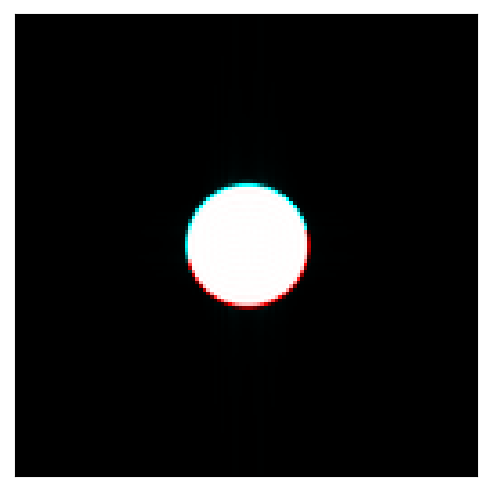

In [18]:
py4DSTEM.show(
    list(np.abs(ptycho_mix.probe_fourier)),
    combine_images=True,
    figsize=(6,6),
    ticks=False,
)

Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|█████████████████████████████████| 16/16 [00:46<00:00,  2.89s/ iter]


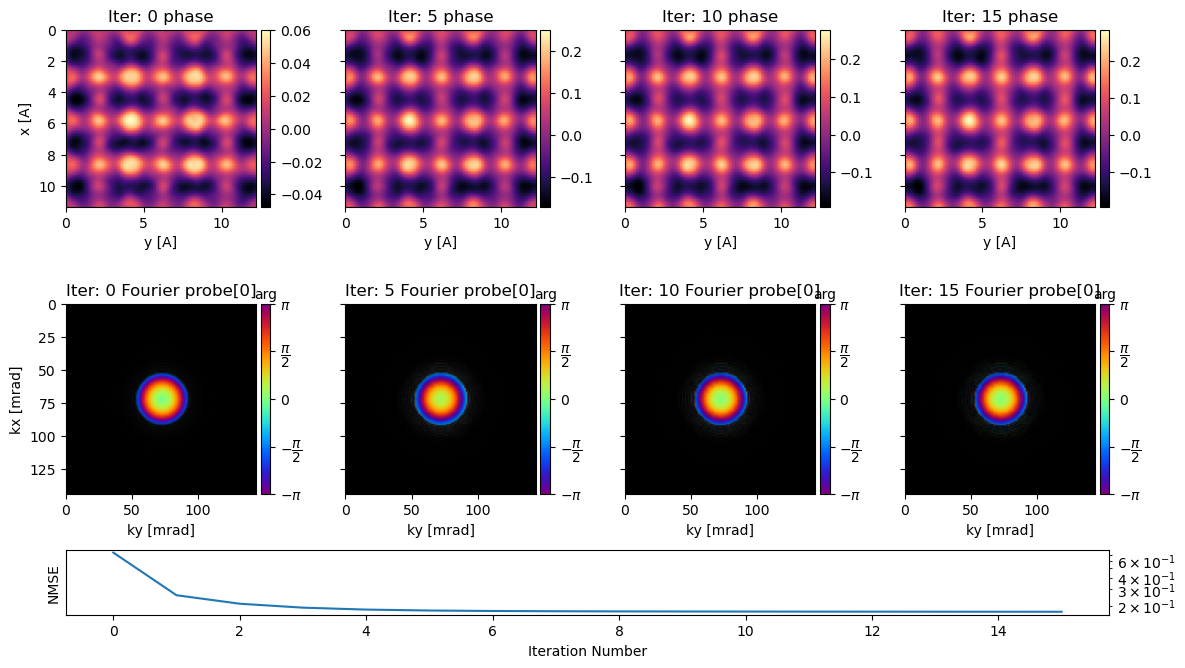

In [19]:
ptycho_mix = ptycho_mix.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    gaussian_filter_sigma=0.125,
    step_size=0.5,
).visualize(
    iterations_grid = 'auto',
    plot_fourier_probe=True,
)

The result does not appear to be all that different, even though the object is slightly better reconstructed.  
Let's see how are two probes look like:

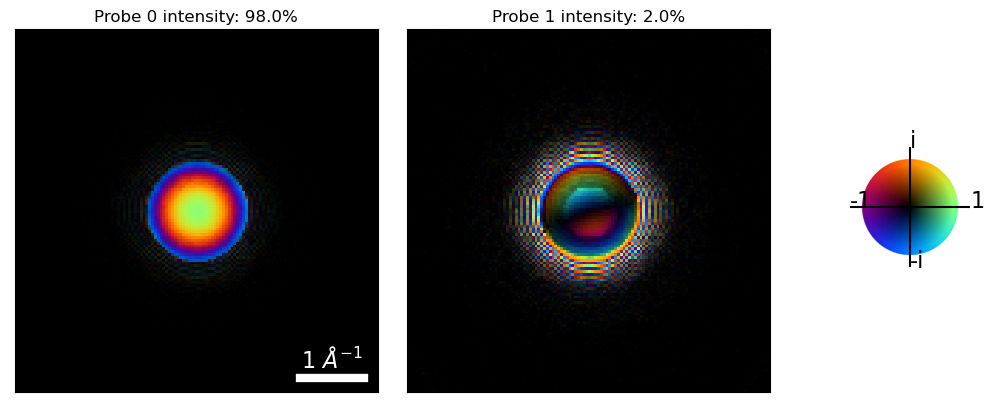

In [20]:
intensity_arrays = np.array([np.abs(probe)**2 for probe in ptycho_mix.probe])
probe_ratio      = [np.sum(intensity_array)/intensity_arrays.sum() for intensity_array in intensity_arrays]

ptycho_mix.show_fourier_probe(
    axsize=(4,4),
    title=[
        f"Probe 0 intensity: {probe_ratio[0]*100:.1f}%",
        f"Probe 1 intensity: {probe_ratio[1]*100:.1f}%",
    ],
)

It looks like our reconstruction did not successfully partition the intensities between the two probes, explaining the almost-identical reconstruction to the single-probe case.

### Batched updates

This turns out to be because of the batched updates we use to update our object/probes. If instead we only update our object/probes using say ~8 probe positions at a time, the algorithm can more easily partition the intensity accordingly. This can be accomplished using the `max_batch_size` parameter:

Performing 16 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.5, in batches of max 8 measurements.


Reconstructing object and probe: 100%|█████████████████████████████████| 16/16 [00:36<00:00,  2.27s/ iter]


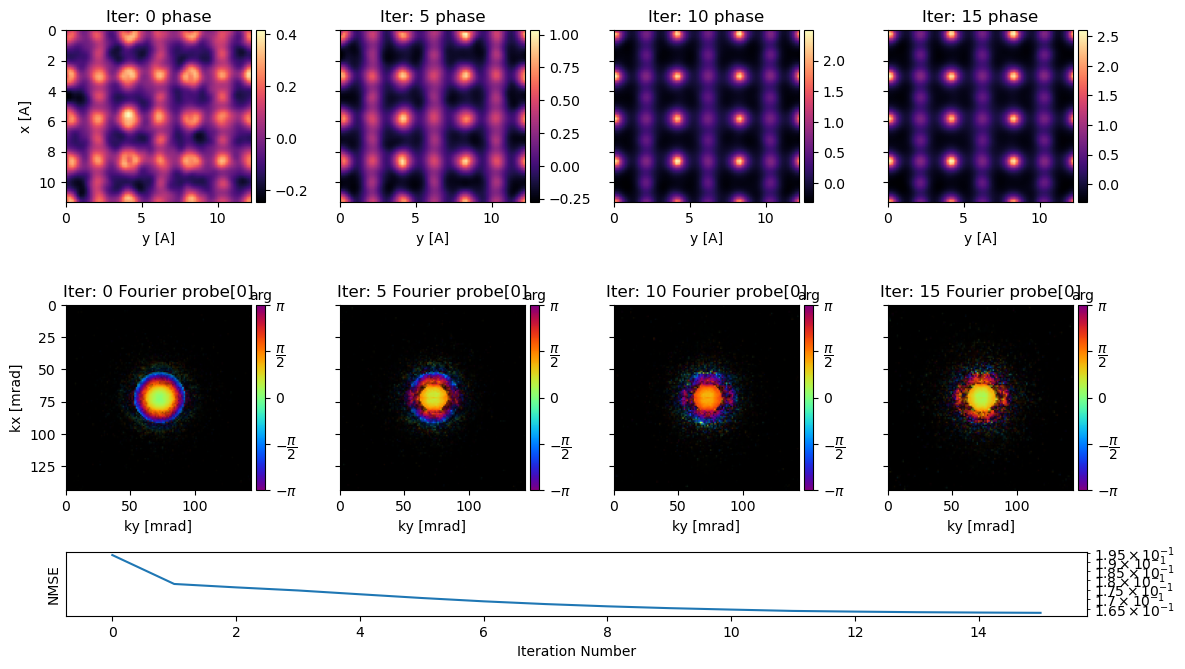

In [21]:
ptycho_mix_batch = ptycho_mix.reconstruct(
    reset=True,
    store_iterations=True,
    max_iter = 16,
    normalization_min=1,
    gaussian_filter_sigma=0.125,
    step_size=0.5,
    max_batch_size=8,
).visualize(
    iterations_grid = 'auto',
    plot_fourier_probe=True,
)

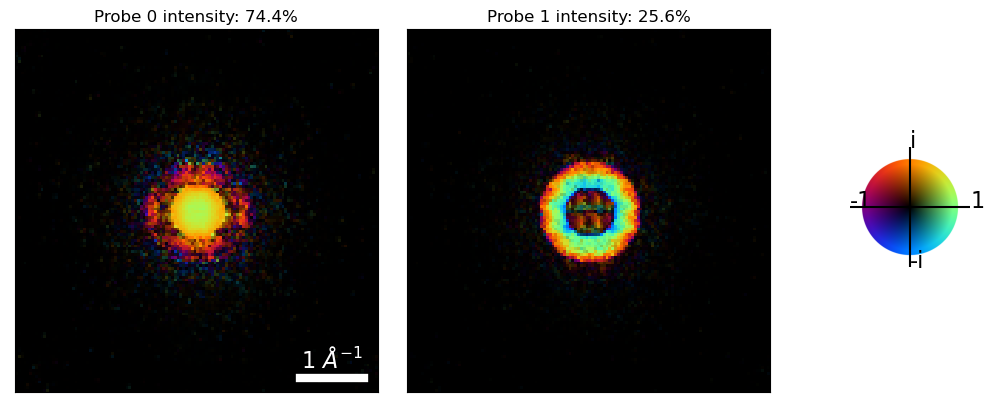

In [22]:
intensity_arrays = np.array([np.abs(probe)**2 for probe in ptycho_mix_batch.probe])
probe_ratio      = [np.sum(intensity_array)/intensity_arrays.sum() for intensity_array in intensity_arrays]

ptycho_mix_batch.show_fourier_probe(
    axsize=(4,4),
    title=[
        f"Probe 0 intensity: {probe_ratio[0]*100:.1f}%",
        f"Probe 1 intensity: {probe_ratio[1]*100:.1f}%",
    ],
)

Indeed, our reconstruction achieves far superior reconstruction quality by properly separating the intensities to the simulated 75% circular aperture, and 25% annular aperture!